# 08_Simple-MLP-unsupervised

Extend the original simple MLP pruning model but change the output task to a self-supervised task.

Clustering like in DrLIM with contrastive loss (Hadsell et. al. 2005)
- The goal was to make a better clustering algorithm
- Use prior knowledge put similar points together vs others
- Trained a siamese network: same network applied on two different data points. Then take the distance of resulting embeddings. Use this distance to calculate the loss.

- They used a CNN. Any idea if this can work on an MLP?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.simple_pruning_growth_model import DrLIMPruneGrowNetwork, ContrastiveLoss, constrative_test_loop
from src.training_testing_loop import full_train, save_model_attr, format_training_outputs, save_training_data
from src.load_MNIST import get_mnist_pairs_loader
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import os
import pickle

In [11]:
from src.training_results import MLPUnsupervisedTrainingResults

For now, directly use the labels to make the pairs. Next, implement pairs that is label agnostic via simple eucledian distance and creating a neighborhood graph

In [32]:
train_pair_dataloader, val_pair_dataloader = get_mnist_pairs_loader(
    batch_size=32, train=True, subset_fraction=0.05, validation_ratio=6, seed=42, 
    selected_labels=[4, 9]
)

device: cpu
num_workers: 1


In [53]:
np.unique(train_pair_dataloader.dataset.dataset.pair_labels, return_counts=True)

(array([0., 1.], dtype=float32), array([562, 616]))

In [54]:
test_pair_dataloader = get_mnist_pairs_loader(batch_size=32, train=False, subset_fraction=0.05,  selected_labels=[4, 9])

device: cuda
num_workers: 0


In [55]:
for X, y in test_pair_dataloader:
    print(X[0].device, X[1].device)
    print(y.device)
    break

cpu cpu
cpu


In [56]:
len(test_pair_dataloader.dataset)

198

Using Tanh activation for the prediction head to see if this help constrain the gradients. Tanh constrains the output to be between -1 and 1.

No Pruning, linear prediction activation

In [10]:
model_state_output_dir = "./outputs/08/DrLIM.2024-12-11"

In [76]:
DrLIM_model = DrLIMPruneGrowNetwork(
    gamma=0.1, init_density=0.5, num_training_iter=500,
    low_mapping_dim=2, prediction_act=lambda x: x, use_grow_prune_prob=False
)

contrastive_loss_fn = ContrastiveLoss(m=5) # if I am using tanh, range is between -1 and 1.
val_contrastive_loss_fn = ContrastiveLoss(m=5, reduction='sum')

train_losses_epoch, val_losses_epoch, test_df, model_state_dicts = full_train(
    DrLIM_model, train_pair_dataloader, val_pair_dataloader, test_pair_dataloader,
    model_training_output_dir=model_state_output_dir,
    override=True,
    learning_rate = 1e-3, 
    loss_fn=contrastive_loss_fn,
    val_loss_fn=val_contrastive_loss_fn,
    plot=False, verbose=False,
    test_loop_func=constrative_test_loop,
    margin=contrastive_loss_fn.m,
    args_expand=True,
)

./outputs/08/DrLIM.2024-12-11 already exists and override is True. Interrupt before training ends to prevent overwriting.


Epochs:  19%|█▉        | 97/500 [02:07<11:46,  1.75s/it]

In [16]:
no_prune_results = MLPUnsupervisedTrainingResults(
    model_state_output_dir, 
    desc='no pruning',
    param_dict={
        "bs": 32, 
        "sf": 0.05, 
        "sl": '49', 
        "vr": 6, 
        "id": 0.5, 
        "nti": 500, 
        "lmd": 2, 
        "pat": 'linear', 
        "m": 5, 
        "ugpp": 'False',
        "lr": 0.001, 
        "s": 42,  # only for the dataloaders
    }
)

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'no pruning Training Losses'}, xlabel='Training and validation epoch/batch', ylabel='loss'>)

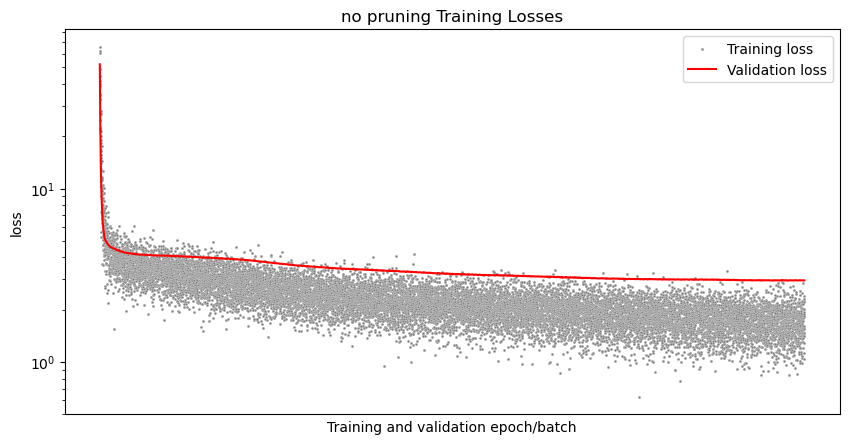

In [21]:
no_prune_results.plot_training_losses()

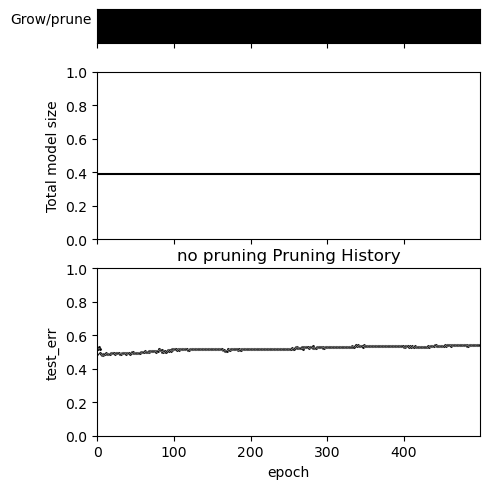

In [29]:
fig, ax = no_prune_results.plot_pruning(norm_size=12704)

In [30]:
with open(f"{model_state_output_dir}/model_attr.pkl", "rb") as fh:
    model_attr = pickle.load(fh)

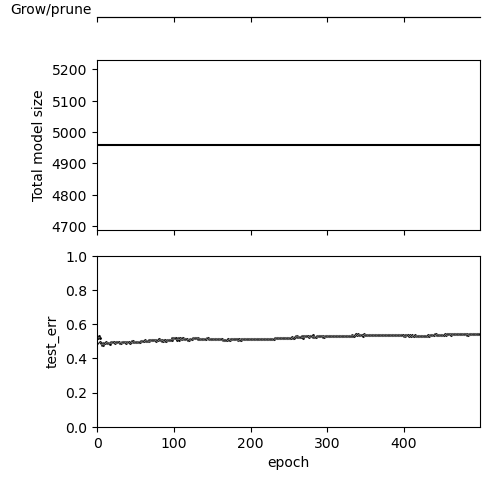

In [31]:
fig, axes = plt.subplots(3, 1, figsize=(5, 5), sharex=True, height_ratios=[1, 5, 5])
axes[0].imshow(np.array(np.array(model_attr['grow_prune_history']).reshape(1, -1)), cmap='gray')
axes[0].set_yticks([])
axes[0].set_ylabel("Grow/prune", rotation=0, ha='right')

axes[1].plot(model_attr['synapse_count_history'], c='k') 
axes[1].set_ylabel("Total model size")

sns.scatterplot(test_df.reset_index(), x='epoch', y='test_err', ax=axes[2], c='k', s=5) 
axes[2].set_ylim(0, 1.0)
plt.tight_layout()
plt.show()


<function MLPUnsupervisedTrainingResults.set_trained_model.<locals>.<lambda> at 0x7f3160c4ef80>


(<Figure size 500x500 with 1 Axes>,
 <Axes: title={'center': '2D Embeddings of Image Pairs'}, xlabel='Embedding dimension 1', ylabel='Embedding dimension 2'>)

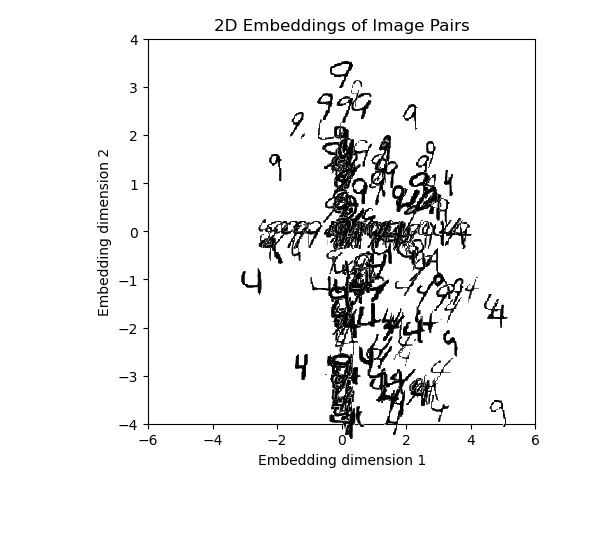

In [37]:
no_prune_results.set_trained_model(499)
no_prune_results.plot_image_embeddings(train_pair_dataloader, num_pairs_per_batch=2)

# Launch GPU jobs

- More data (50% of MNIST), more epochs (500)
- Linear vs tanh

In [3]:
output_dir = "/home/clc926/Desktop/klab_rotation/outputs/08/bs-32_sf-0.05_sl-49_vr-6_id-0.5_nti-50_lmd-2_pat-linear_m-5.0_ugpp-True_lr-0.001_s-4/54774784"
test_stack_training_losses_df = pd.read_csv(f"{output_dir}/stack_training_losses.tsv", sep='\t')
test_stack_val_losses_df = pd.read_csv(f"{output_dir}/stack_val_losses.tsv", sep='\t')
test_test_df = pd.read_csv(f"{output_dir}/test_err_loss.tsv", sep='\t')

In [7]:
test_results = MLPUnsupervisedTrainingResults(output_dir, desc_split_idx=-1, param_split_idx=-2)

(<Figure size 500x500 with 3 Axes>,
 array([<Axes: ylabel='Grow/prune'>, <Axes: ylabel='Total model size'>,
        <Axes: title={'center': '54774784 Pruning History'}, xlabel='epoch', ylabel='test_err'>],
       dtype=object))

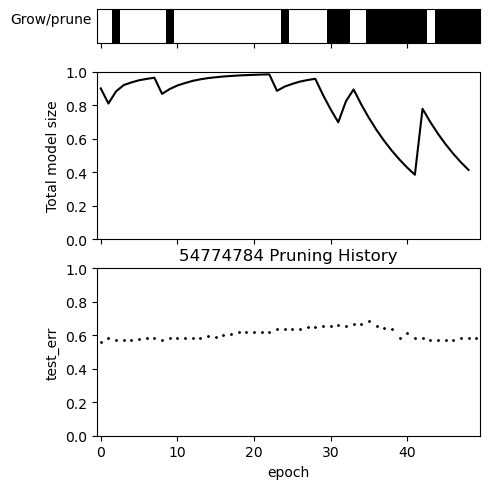

In [9]:
test_results.plot_pruning(norm_size=12704)

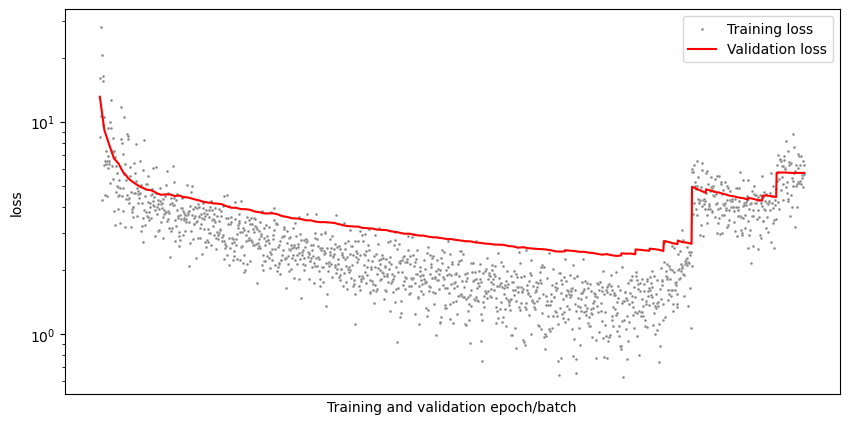

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(test_stack_training_losses_df.reset_index(), x='index', y='loss', label='Training loss', alpha=1.0, c='gray', s=4, ax=ax)
sns.lineplot(test_stack_val_losses_df.reset_index(), x='index', y='loss',  label='Validation loss', c='red', ax=ax)
plt.xticks([])
plt.xlabel('Training and validation epoch/batch')
plt.yscale('log')
plt.show()